<a href="https://colab.research.google.com/github/payalpadmanabhan/Data298B-Crime/blob/main/Audio_Recognition_and_Classification_using_YAMNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Mounting our Google Drive to Google Colab**

In [21]:
# We are mounting our google drive to google colab to be able to download files directly into the drive.

from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [22]:
# Downloading a video directly from YouTube.

!pip install yt-dlp
!yt-dlp https://www.youtube.com/watch?v=obFUHMJ0Y_8 #Please provide the link of the video that needs to be downloaded.

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
[youtube] obFUHMJ0Y_8: Downloading webpage
[youtube] obFUHMJ0Y_8: Downloading android player API JSON
[info] obFUHMJ0Y_8: Downloading 1 format(s): 248+251
[download] Destination: Woman Screams for Her Life on Doorbell Camera Footage [obFUHMJ0Y_8].f248.webm
[download] 100% of   14.69MiB in 00:00:00 at 45.81MiB/s
[download] Destination: Woman Screams for Her Life on Doorbell Camera Footage [obFUHMJ0Y_8].f251.webm
[download] 100% of    1.07MiB in 00:00:00 at 52.11MiB/s
[Merger] Merging formats into "Woman Screams for Her Life on Doorbell Camera Footage [obFUHMJ0Y_8].webm"
Deleting original file Woman Screams for Her Life on Doorbell Camera Footage [obFUHMJ0Y_8].f251.webm (pass -k to keep)
Deleting original file Woman Screams for Her Life on Doorbell Camera Footage [obFUHMJ0Y_8].f248.webm (pass -k to keep)


## **Extracting audio from the downloaded video using MoviePy**

In [23]:
!pip install ffmpeg moviepy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [24]:
!pip3 install imageio==2.4.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [25]:
!pip install --upgrade imageio-ffmpeg

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [27]:
import moviepy.editor as mp

#Please enter the name of the video file that is downloaded into the drive

my_clip = mp.VideoFileClip(r"woman_screams.webm") 
my_clip

In [28]:
# Extracted the audio from the video and writing it into the file

my_clip.audio.write_audiofile(r"ws_audio.wav") # Give a name for the audio file 

[MoviePy] Writing audio in ws_audio.wav


100%|██████████| 1843/1843 [00:01<00:00, 1796.28it/s]

[MoviePy] Done.


## **Loading the pre-trained YAMNet model and Checking the audio sample requirements**

In [29]:
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
import csv

import matplotlib.pyplot as plt
from IPython.display import Audio
from scipy.io import wavfile

In [30]:
# Load the YAMNet model

model = hub.load('https://tfhub.dev/google/yamnet/1')

In [31]:
# Find the name of the class with the top score when mean-aggregated across frames.

def class_names_from_csv(class_map_csv_text):
  """Returns list of class names corresponding to score vector."""
  class_names = []
  with tf.io.gfile.GFile(class_map_csv_text) as csvfile:
    reader = csv.DictReader(csvfile)
    for row in reader:
      class_names.append(row['display_name'])

  return class_names

class_map_path = model.class_map_path().numpy()
class_names = class_names_from_csv(class_map_path)

In [32]:
# Checking the audio file to make sure the sample rate if 16KHz

def ensure_sample_rate(original_sample_rate, waveform,
                       desired_sample_rate=16000):
  """Resample waveform if required."""
  if original_sample_rate != desired_sample_rate:
    desired_length = int(round(float(len(waveform)) /
                               original_sample_rate * desired_sample_rate))
    waveform = scipy.signal.resample(waveform, desired_length)
  return desired_sample_rate, waveform

## **Converting the audio from Stereo to Mono**

In [33]:
pip install pydub

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [34]:
from pydub import AudioSegment

# Enter the path of the audio file you want converted from stereo to mono

stereo_audio = AudioSegment.from_file("/content/ws_audio.wav",format="wav")
mono_audios = stereo_audio.split_to_mono()
mono_left = mono_audios[0].export("/content/ws_audio_mono.wav",format="wav") # Give a name for the audio file 

In [35]:
import scipy
#import scipy.io.wavfile
#wav_file_name = 'speech_whistling2.wav'
wav_file_name = 'ws_audio_mono.wav'
sample_rate, wav_data = wavfile.read(wav_file_name, 'rb')
sample_rate, wav_data = ensure_sample_rate(sample_rate, wav_data)

# Show some basic information about the audio.
duration = len(wav_data)/sample_rate
print(f'Sample rate: {sample_rate} Hz')
print(f'Total duration: {duration:.2f}s')
print(f'Size of the input: {len(wav_data)}')

# Listening to the wav file.
Audio(wav_data, rate=sample_rate)

Sample rate: 16000 Hz
Total duration: 83.56s
Size of the input: 1336960


In [36]:
waveform = wav_data / tf.int16.max

In [37]:
# Run the model, check the output.
scores, embeddings, spectrogram = model(waveform)

In [38]:
scores_np = scores.numpy()
spectrogram_np = spectrogram.numpy()
infered_class = class_names[scores_np.mean(axis=0).argmax()]
print(f'The main sound is: {infered_class}')

The main sound is: Speech


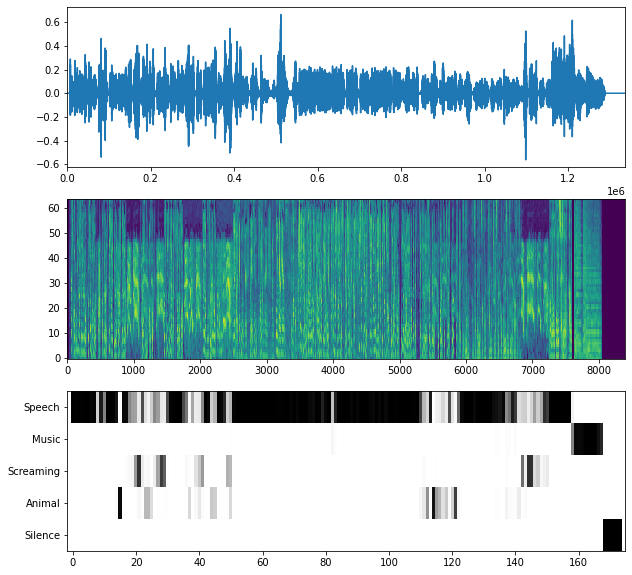

In [39]:
plt.figure(figsize=(10, 10))

# Plot the waveform.
plt.subplot(3, 1, 1)
plt.plot(waveform)
plt.xlim([0, len(waveform)])

# Plot the log-mel spectrogram (returned by the model).
plt.subplot(3, 1, 2)
plt.imshow(spectrogram_np.T, aspect='auto', interpolation='nearest', origin='lower')

# Plot and label the model output scores for the top-scoring classes.
mean_scores = np.mean(scores, axis=0)
top_n = 5
top_class_indices = np.argsort(mean_scores)[::-1][:top_n]
plt.subplot(3, 1, 3)
plt.imshow(scores_np[:, top_class_indices].T, aspect='auto', interpolation='nearest', cmap='gray_r')

# patch_padding = (PATCH_WINDOW_SECONDS / 2) / PATCH_HOP_SECONDS
# values from the model documentation
patch_padding = (0.025 / 2) / 0.01
plt.xlim([-patch_padding-0.5, scores.shape[0] + patch_padding-0.5])
# Label the top_N classes.
yticks = range(0, top_n, 1)
plt.yticks(yticks, [class_names[top_class_indices[x]] for x in yticks])
_ = plt.ylim(-0.5 + np.array([top_n, 0]))